In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc

import os
import time
import sys

from sklearn.externals import joblib

In [3]:
df = pd.read_csv("titanic_train.csv")

In [4]:
df.shape

(891, 12)

In [5]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 1. Exploration and Data Cleansing

PassengerID is not usable for machine leanin. Same with Name. Let's drop these.

In [8]:
del df["PassengerId"]

In [9]:
del df["Name"]

In [10]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


But what about Ticket? What is this field indicative and how unique is it?

In [11]:
len(set(df.Ticket))

681

We are going to avoid using Ticket due to high uniqueness. 

In [12]:
del df["Ticket"]

In [13]:
df.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [14]:
df.dtypes.reset_index()

,index,0
0,Survived,int64
1,Pclass,int64
2,Sex,object
3,Age,float64
4,SibSp,int64
5,Parch,int64
6,Fare,float64
7,Cabin,object
8,Embarked,object


In [15]:
cat_cols = [
    "Sex",
    "Cabin",
    "Embarked"
]

In [16]:
num_cols = [
    "Survived",
    "Pclass",
    "Age",
    "SibSp",
    "Parch",
    "Fare"
]

In [17]:
for col in cat_cols:
    print(col, len(df.loc[df[col].isna()]))

Sex 0
Cabin 687
Embarked 2


Yikes, Cabin has 687 missing rows. We should drop this column.  
Sex has no missing rows, great!  
Embarked can still be used, if it is indicative of Survival. 

In [18]:
del df["Cabin"]

In [19]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [20]:
for col in num_cols:
    print(col, len(df.loc[df[col].isna()]))

Survived 0
Pclass 0
Age 177
SibSp 0
Parch 0
Fare 0


Age has 177 rows missing... if I drop these, I would be reducing my total dataset quite a bit... what about imputation?!  
I know that Sex has no missing rows...

In [21]:
df.groupby("Sex").mean()["Age"]

Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64

The average age of females on Titanic was 27.915709 and the average age of males was 30.726645.  

In [22]:
df.loc[(df.Age.isna()) & (df.Sex == "male"), "Age"]= 30.726645

In [23]:
df.loc[(df.Age.isna()) & (df.Sex == "female"), "Age"]= 27.915709

# CHECKPOINT -- I have a clean dataset to work with at this point

# 2. Visualization 

In [24]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [25]:
df.Survived.value_counts() / len(df)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Good balance, of roughly 40% positive events and 60% negative events.

Text(0.5, 1.0, 'Survival Counts - 1 is Survived')

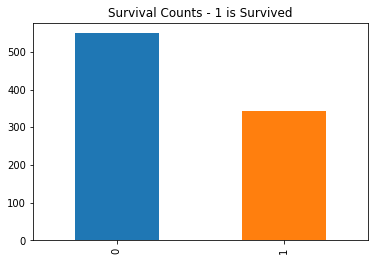

In [26]:
df.Survived.value_counts().plot(kind="bar")
plt.title("Survival Counts - 1 is Survived")

# single variable distributions first

/home/xuren/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


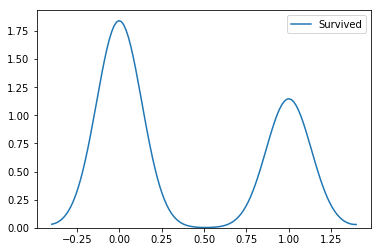

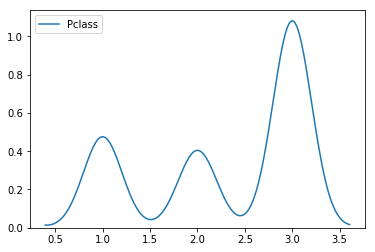

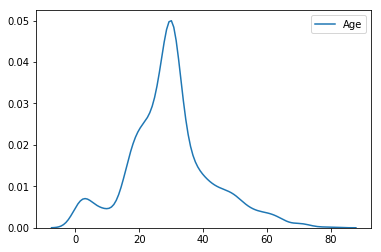

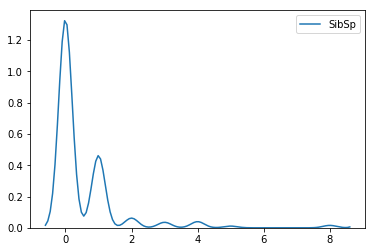

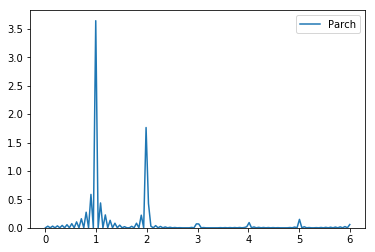

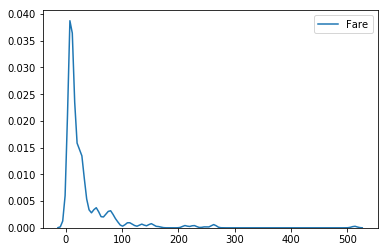

In [27]:
for col in num_cols:
    sns.kdeplot(df[col])
    plt.show()

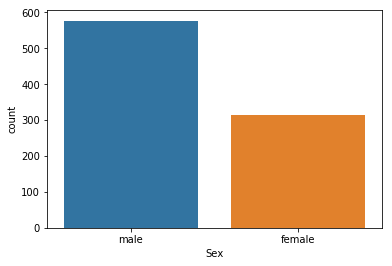

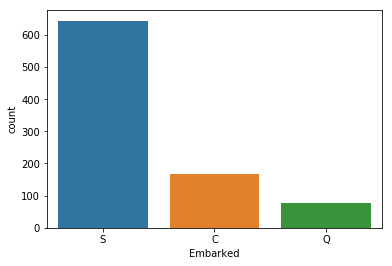

In [28]:
cat_cols = [
    "Sex",
    "Embarked"
]

for col in cat_cols:
    sns.countplot(col, data=df)
    plt.show()

There is a lot of skew in SibSp, Parch, and Fare. Good candiates for aggregation or transformation.

Pclass is being represented here as a numeric, but does it make more sense to turn it into a categorical variable? 

# look at univariate and multi-variate relationships against Survival

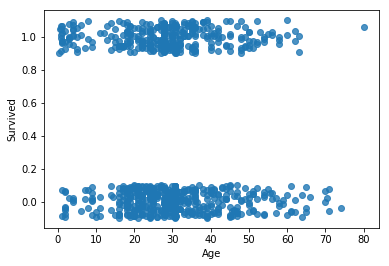

In [29]:
sns.regplot(x="Age", y="Survived", data=df, fit_reg=False, y_jitter=0.1)

Come back to age... it looks like there might be some significance, particularly in that cluster of < 10 years old

In [30]:
def makeUniPlot(xinput):
    sns.regplot(x=xinput, y="Survived", data=df, fit_reg=False, y_jitter=0.1, x_jitter=0.1, scatter_kws={"alpha": 0.2})
    plt.show()

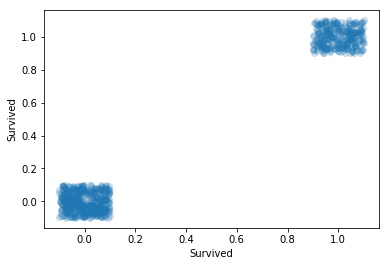

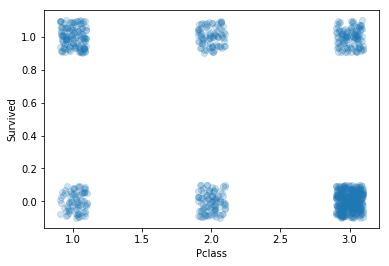

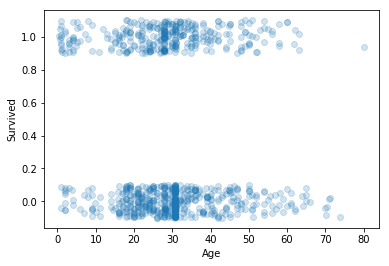

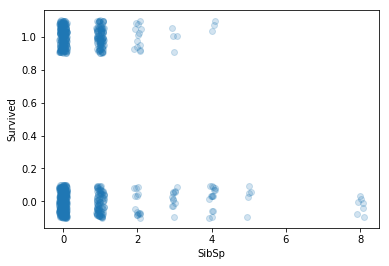

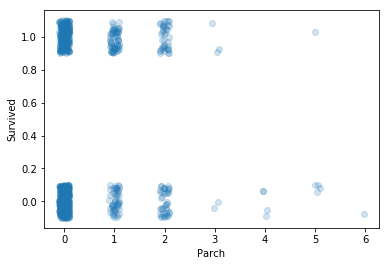

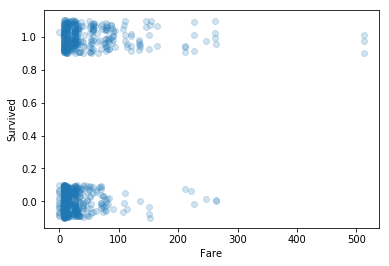

In [31]:
for col in num_cols:
    makeUniPlot(col)

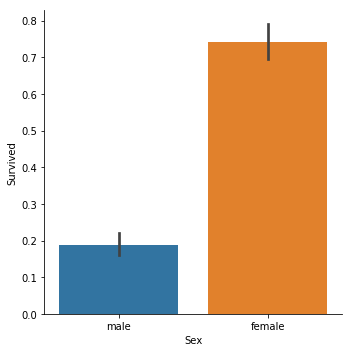

In [32]:
sns.catplot(x="Sex", y="Survived", data=df, kind="bar")

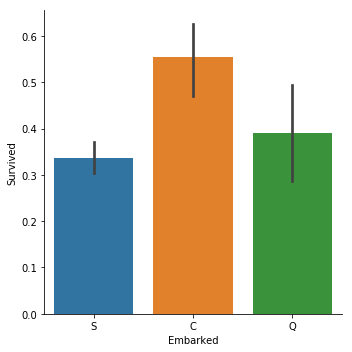

In [33]:
sns.catplot(x="Embarked", y="Survived", data=df, kind="bar")

In [34]:
plt.style.use("seaborn")

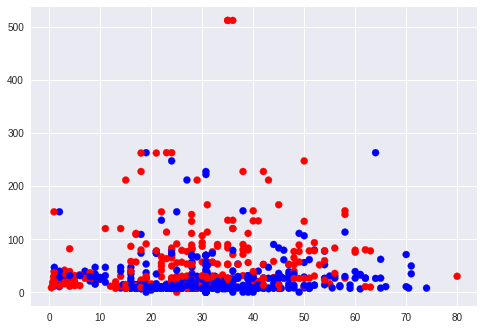

In [35]:
plt.scatter(x=df.Age, y=df.Fare, c=df.Survived, cmap="bwr")

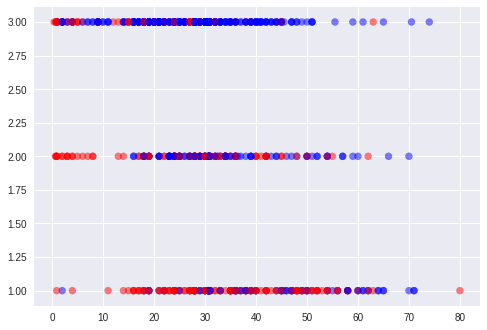

In [36]:
plt.scatter(x=df.Age, y=df.Pclass, c=df.Survived, cmap="bwr", alpha=0.5)

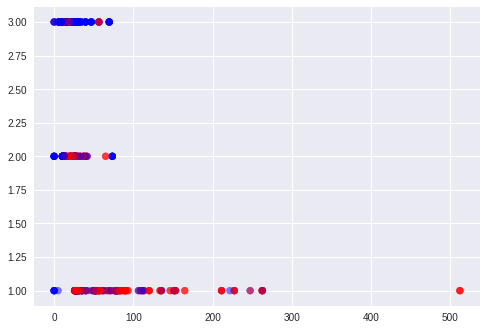

In [37]:
plt.scatter(x=df.Fare, y=df.Pclass, c=df.Survived, cmap="bwr", alpha=0.5)

/home/xuren/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


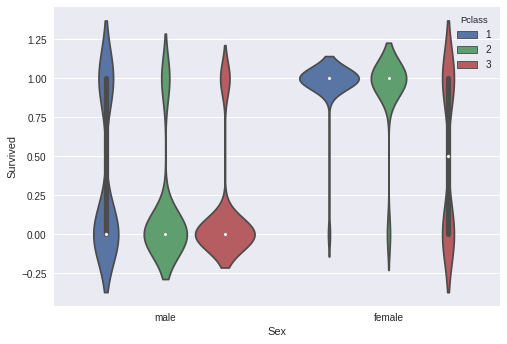

In [38]:
sns.violinplot(x="Sex", y="Survived", data=df, hue="Pclass")

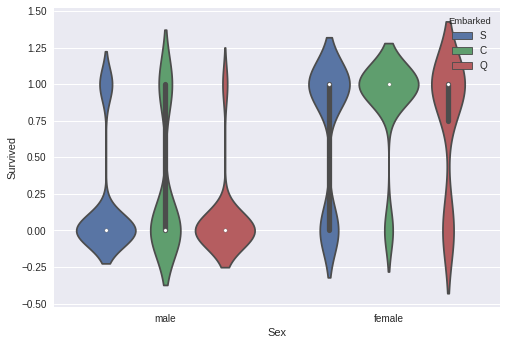

In [39]:
sns.violinplot(x="Sex", y="Survived", data=df, hue="Embarked")

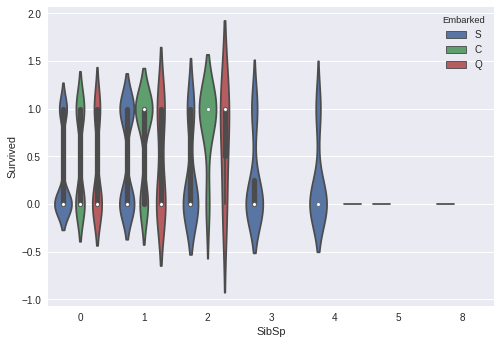

In [40]:
sns.violinplot(x="SibSp", y="Survived", data=df, hue="Embarked")

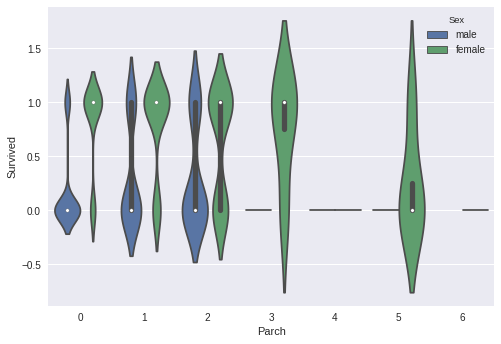

In [41]:
sns.violinplot(x="Parch", y="Survived", data=df, hue="Sex")

# 3 Feature Engineering

Recall that we can create some binary indicators as well as dummy variables for some of our features. Also, we noted that some numerical variables, like Pclass, really should be converted to a categorical variable. 

In [42]:
# I will create a new col here so I don't overwrite original data fields
df["cat_pclass"] = df["Pclass"].astype(str)

In [43]:
df.dtypes

Survived        int64
Pclass          int64
Sex            object
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked       object
cat_pclass     object
dtype: object

In [44]:
# create a binary indicator that sipsp exists
df["bin_sibsp"] = df.apply(lambda r: 1 if r.SibSp > 0 else 0, axis=1)

In [45]:
# create a binary indicator that Parch exists
df["bin_parch"] = df.apply(lambda r: 1 if r.Parch > 0 else 0, axis=1)

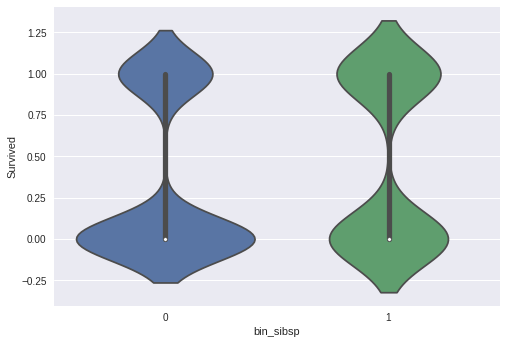

In [46]:
sns.violinplot(x="bin_sibsp", y="Survived", data=df)

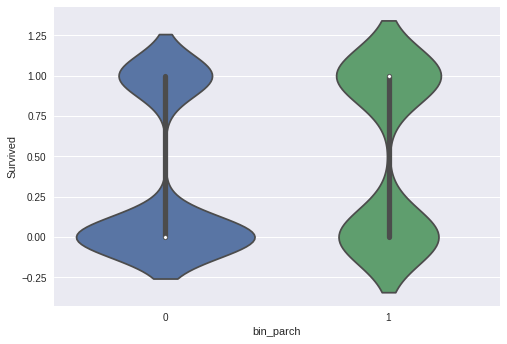

In [47]:
sns.violinplot(x="bin_parch", y="Survived", data=df)

# 4 Feature Selection or Feature Importance

I've done some visual exploration, and I have a sense of which features are good to use. But do they all matter? Should I use all of them? Which ones are the most important?  

As is often the case, the answer to these questions is to use some iteration and math!  

In [48]:
df.columns


Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'cat_pclass', 'bin_sibsp', 'bin_parch'],
      dtype='object')

In [209]:
features_to_use = [
    "Sex",
    "Age",
    "Fare",
    "Embarked",
    "cat_pclass",
    "bin_sibsp",
    "bin_parch"
]

In [210]:
X = df[features_to_use]

In [211]:
y = df[["Survived"]]

In [212]:
X.head()

,Sex,Age,Fare,Embarked,cat_pclass,bin_sibsp,bin_parch
0,male,22.0,7.2500,S,3,1,0
1,female,38.0,71.2833,C,1,1,0
2,female,26.0,7.9250,S,3,0,0
3,female,35.0,53.1000,S,1,1,0
4,male,35.0,8.0500,S,3,0,0


In [213]:
y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [214]:
X_encoded = pd.get_dummies(X)

In [215]:
# inital tests for feature importances

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

In [217]:
X_train.shape, X_test.shape

((668, 12), (223, 12))

In [218]:
y_train.shape, y_test.shape

((668, 1), (223, 1))

In [219]:
X_train.head()

,Age,Fare,bin_sibsp,bin_parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,cat_pclass_1,cat_pclass_2,cat_pclass_3
298,30.726645,30.5000,0,0,0,1,0,0,1,1,0,0
884,25.000000,7.0500,0,0,0,1,0,0,1,0,0,1
247,24.000000,14.5000,0,1,1,0,0,0,1,0,1,0
478,22.000000,7.5208,0,0,0,1,0,0,1,0,0,1
305,0.920000,151.5500,1,1,0,1,0,0,1,1,0,0


In [173]:
# normalize
sds = StandardScaler()
sds.fit(X_train)
X_train = sds.transform(X_train)
X_test = sds.transform(X_test)

In [174]:
sds

StandardScaler(copy=True, with_mean=True, with_std=True)

In [62]:
joblib.dump(sds, "scaler.model")

['scaler.model']

In [63]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,-4.238127e-17,-3.240921e-17,-1.037095e-16,1.170055e-16,1.934580e-16,-1.934580e-16,8.625835e-17,-1.881396e-16,-3.280809e-16,1.495809e-16,1.116871e-16,-6.648042e-18
std,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00
min,-2.236751e+00,-6.240505e-01,-6.865607e-01,-5.519851e-01,-7.222466e-01,-1.384569e+00,-4.608049e-01,-3.083536e-01,-1.665536e+00,-5.427464e-01,-5.172545e-01,-1.131311e+00
25%,-5.784634e-01,-4.703621e-01,-6.865607e-01,-5.519851e-01,-7.222466e-01,-1.384569e+00,-4.608049e-01,-3.083536e-01,-1.665536e+00,-5.427464e-01,-5.172545e-01,-1.131311e+00
50%,3.628641e-02,-3.447933e-01,-6.865607e-01,-5.519851e-01,-7.222466e-01,7.222466e-01,-4.608049e-01,-3.083536e-01,6.004072e-01,-5.427464e-01,-5.172545e-01,8.839306e-01
75%,4.205050e-01,-3.256830e-02,1.456535e+00,-5.519851e-01,1.384569e+00,7.222466e-01,-4.608049e-01,-3.083536e-01,6.004072e-01,-5.427464e-01,-5.172545e-01,8.839306e-01
max,3.878473e+00,9.311478e+00,1.456535e+00,1.811643e+00,1.384569e+00,7.222466e-01,2.170116e+00,3.243030e+00,6.004072e-01,1.842481e+00,1.933284e+00,8.839306e-01


In [64]:
pd.DataFrame(X_test).describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.063937,0.001922,-0.023450,0.052171,0.080800,-0.080800,0.140885,-0.005769,-0.110876,0.141803,-0.044729,-0.083024
std,0.998914,0.845108,0.992882,1.033336,1.025526,1.025526,1.107460,0.993712,1.053938,1.081408,0.968954,1.009065
min,-2.205245,-0.624051,-0.686561,-0.551985,-0.722247,-1.384569,-0.460805,-0.308354,-1.665536,-0.542746,-0.517254,-1.131311
25%,-0.501620,-0.470928,-0.686561,-0.551985,-0.722247,-1.384569,-0.460805,-0.308354,-1.665536,-0.542746,-0.517254,-1.131311
50%,0.036286,-0.328391,-0.686561,-0.551985,-0.722247,0.722247,-0.460805,-0.308354,0.600407,-0.542746,-0.517254,0.883931
75%,0.497349,-0.016448,1.456535,1.811643,1.384569,0.722247,-0.460805,-0.308354,0.600407,1.842481,-0.517254,0.883931
max,3.186879,4.464151,1.456535,1.811643,1.384569,0.722247,2.170116,3.243030,0.600407,1.842481,1.933284,0.883931


In [65]:
for i in range(5):
    
    t0 = time.time()
    clf = DecisionTreeClassifier()
    
    clf.fit(X_train, y_train)
    t1 = time.time()
    
    ypred = clf.predict(X_test)
    scores = roc_auc_score(y_test, ypred)
    
    print(f"Decision tree {i+1} took {t1-t0} seconds to train and got a score of {scores}")
    print()
    print("And here are the top features: ")
    c = X_encoded.columns 
    for cfi in zip(c, clf.feature_importances_):
        print(cfi)
    print()
    

Decision tree 1 took 0.0033206939697265625 seconds to train and got a score of 0.743795069595841

And here are the top features: 
('Age', 0.2545149526993415)
('Fare', 0.24994398336498727)
('bin_sibsp', 0.00759814383189323)
('bin_parch', 0.013926722752857326)
('Sex_female', 0.30686413386834854)
('Sex_male', 0.0)
('Embarked_C', 0.009159790866592576)
('Embarked_Q', 0.001110101088995874)
('Embarked_S', 0.019093738730729032)
('cat_pclass_1', 0.02372209344557314)
('cat_pclass_2', 0.0)
('cat_pclass_3', 0.11406633935068147)

Decision tree 2 took 0.0035064220428466797 seconds to train and got a score of 0.7362904578232434

And here are the top features: 
('Age', 0.260159833371767)
('Fare', 0.24742511113209908)
('bin_sibsp', 0.01181652797007755)
('bin_parch', 0.008710023929044549)
('Sex_female', 0.0)
('Sex_male', 0.30686413386834843)
('Embarked_C', 0.01582039740056782)
('Embarked_Q', 0.003108283049188447)
('Embarked_S', 0.00599454588057772)
('cat_pclass_1', 0.020391790178585518)
('cat_pclass_2',

In [220]:
features_to_use = [
    "Sex_female",
    "Age",
    "Fare",
    "cat_pclass_3",
    "bin_sibsp",
    "bin_parch"
]

# 5 Model Selection, Model Benchmark

In [221]:
X_encoded[features_to_use].shape

(891, 6)

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded[features_to_use], y, random_state=42)

In [223]:
pd.concat([X_train, y_train], axis=1).head()

,Sex_female,Age,Fare,cat_pclass_3,bin_sibsp,bin_parch,Survived
298,0,30.726645,30.5000,0,0,0,1
884,0,25.000000,7.0500,1,0,0,0
247,1,24.000000,14.5000,0,0,1,1
478,0,22.000000,7.5208,1,0,0,0
305,0,0.920000,151.5500,0,1,1,1


In [224]:
sds = StandardScaler()
sds.fit(X_train)
X_train = sds.transform(X_train)
X_test = sds.transform(X_test)

/home/xuren/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/xuren/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/xuren/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [225]:
np.mean(X_train, axis=0)

array([ 3.72290356e-17, -3.19106019e-17, -4.52066860e-17, -2.65921683e-17,
       -2.92513851e-17, -2.12737346e-17])

In [226]:
np.mean(X_test, axis=0)

array([ 0.08079963,  0.06393744,  0.00192249, -0.08302365, -0.02345027,
        0.05217106])

In [227]:
sds.mean_

array([ 0.34281437, 29.52778959, 32.17939671,  0.56137725,  0.32035928,
        0.23353293])

In [228]:
sds.var_

array([2.25292678e-01, 1.69349201e+02, 2.65898757e+03, 2.46232834e-01,
       2.17729212e-01, 1.78995303e-01])

In [229]:
joblib.dump(sds, "scaler.model")

['scaler.model']

In [230]:
def modelbench(classifier, X_train, Y_train):
    
    rs = ShuffleSplit(n_splits=3, test_size=.33)
    
    rs.get_n_splits(X_train)
    
    Y_train = Y_train.values
    Y_train = Y_train.ravel()

    for train_idx, test_idx in rs.split(X_train):
        ssX_train, ssX_test = X_train[train_idx], X_train[test_idx]
        ssy_train, ssy_test = Y_train[train_idx], Y_train[test_idx]

        t0 = time.time()
        
        clf = classifier
        clf.fit(X=ssX_train, y=ssy_train)

        ypred = clf.predict(ssX_test)

        scores = roc_auc_score(ssy_test, ypred)
    
        t1 = time.time()
    
        print(f"{classifier} \n took {t1-t0} seconds to run and got a score of {scores}")
        print()

In [231]:
modelbench(DecisionTreeClassifier(), X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 
 took 0.0026404857635498047 seconds to run and got a score of 0.7717049241021845

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 
 took 0.0022585391998291016 seconds to run and got a score of 0.7630382569909075

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
      

In [233]:
modelbench(LogisticRegression(), X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 
 took 0.0025959014892578125 seconds to run and got a score of 0.7886893743058127

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 
 took 0.002259969711303711 seconds to run and got a score of 0.7492279979413279

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 
 took 0.002162933349609375 seconds to run 

/home/xuren/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/xuren/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/xuren/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [234]:
modelbench(RandomForestClassifier(), X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
 took 0.013977289199829102 seconds to run and got a score of 0.7082069430401078

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
 took 0.01292109489440918 seconds to run and got a score of 0.8709663

/home/xuren/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [235]:
modelbench(RandomForestClassifier(n_estimators=50), X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
 took 0.05636262893676758 seconds to run and got a score of 0.7768065268065267

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
 took 0.04563641548156738 seconds to run and got a score of 0.79474885

In [236]:
modelbench(RandomForestClassifier(n_estimators=100), X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
 took 0.0992732048034668 seconds to run and got a score of 0.8110902255639098

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
 took 0.08319282531738281 seconds to run and got a score of 0.7648351

In [237]:
modelbench(SVC(kernel="linear"), X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) 
 took 0.006106853485107422 seconds to run and got a score of 0.7745148110316651

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) 
 took 0.007029533386230469 seconds to run and got a score of 0.838970588235294

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) 
 took 0.0070209503173828125 seconds to run and got a score of 0.7779411764705884



In [238]:
modelbench(SVC(kernel="sigmoid"), X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) 
 took 0.012384176254272461 seconds to run and got a score of 0.757291130554126

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) 
 took 0.010934114456176758 seconds to run and got a score of 0.6233111072117916

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) 
 took 0.010840177536010742 seconds to run and got a score of 0.6981826241134751



/home/xuren/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/xuren/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/xuren/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# 6 RandomForest is Awesome, and It's Fast Enough! So It's Time to Tune!

Doing so using GridSearch

In [239]:
params = {
    "max_depth": [2,4,6,8,10],
    "min_samples_split": [5, 9, 19],
    "min_samples_leaf": [2, 5, 10],
    "max_leaf_nodes": [15, 20, 50],
}

In [240]:
grid = GridSearchCV(RandomForestClassifier(n_estimators=10), params, cv=5)

In [241]:
grid

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [5, 9, 19], 'min_samples_leaf': [2, 5, 10], 'max_leaf_nodes': [15, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [242]:
grid.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [5, 9, 19], 'min_samples_leaf': [2, 5, 10], 'max_leaf_nodes': [15, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [243]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [244]:
grid.best_params_

{'max_depth': 10,
 'max_leaf_nodes': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 9}

In [245]:
n_trees = [10,25,50,75,100,150,200]

train_auc = []
test_auc = []

for i in n_trees:
    clf = RandomForestClassifier(n_estimators=i, random_state=1)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))
    
train_auc, test_auc

([0.9584027810848136,
  0.9749845230725273,
  0.9750797657031288,
  0.977056050288109,
  0.9778275155959807,
  0.9778275155959807,
  0.977056050288109],
 [0.8055089719939627,
  0.784923696126111,
  0.7980043602213651,
  0.7904997484487672,
  0.7923863826932753,
  0.7923863826932753,
  0.7886550394096931])

In [246]:
n_trees = [10,25,50,75,100,150,200]

train_auc = []
test_auc = []

for i in n_trees:
    clf = RandomForestClassifier(max_depth=10, n_estimators=i, random_state=1)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))
    

In [247]:
train_auc, test_auc

([0.9216248392780608,
  0.933915900757179,
  0.9390732892042478,
  0.9370970046192676,
  0.9370970046192676,
  0.9390732892042478,
  0.941049573789228],
 [0.7904578232433339,
  0.7942310917323494,
  0.7998490692604394,
  0.7998490692604394,
  0.8035804125440215,
  0.8073117558276035,
  0.8035804125440215])

In [248]:
n_trees = [10,25,50,75,100,150]

train_auc = []
test_auc = []

for i in n_trees:
    clf = RandomForestClassifier(max_depth=10, max_leaf_nodes=20, n_estimators=i, random_state=1)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

train_auc, test_auc

([0.8336111243392541,
  0.8337063669698557,
  0.8388637554169245,
  0.8388637554169245,
  0.8408400400019047,
  0.8408400400019047],
 [0.7791799429817206,
  0.7885292637933926,
  0.7885292637933926,
  0.7885292637933926,
  0.7922606070769748,
  0.7922606070769748])

In [249]:
n_trees = [10,25,50,75,100,150]

train_auc = []
test_auc = []

for i in n_trees:
    clf = RandomForestClassifier(max_depth=10, max_leaf_nodes=20, min_samples_split=9,
                                 n_estimators=i, random_state=1)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

train_auc, test_auc

([0.8453735892185343,
  0.8352492975855993,
  0.8404066860326681,
  0.8416115053097766,
  0.838430401447688,
  0.8364541168627077],
 [0.7866845547543183,
  0.7922606070769748,
  0.7941472413214825,
  0.7978785846050647,
  0.7941472413214825,
  0.7959919503605568])

In [250]:
n_trees = [10,25,50,75,100,150]

train_auc = []
test_auc = []

for i in n_trees:
    clf = RandomForestClassifier(max_depth=10, max_leaf_nodes=20, min_samples_split=9,
                                 n_estimators=i)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

train_auc, test_auc

([0.8353445402162007,
  0.8289823324920235,
  0.8309586170770037,
  0.8376589361398161,
  0.8344778322777275,
  0.8396352207247963],
 [0.7754485996981385,
  0.7810246520207949,
  0.7922606070769748,
  0.8016099278886467,
  0.7847979205098105,
  0.7829112862653027])

Doing some manual checks

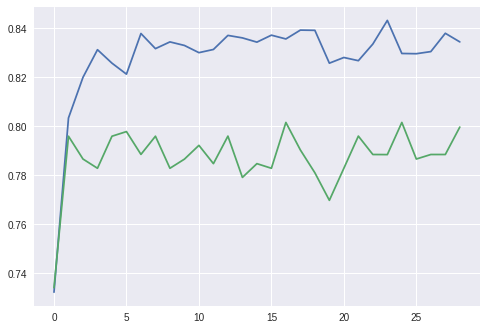

In [251]:
train_auc = []
test_auc = []

for i in range(1,30):
    clf = RandomForestClassifier(max_depth=i, max_leaf_nodes=20, min_samples_split=9,
                                 n_estimators=25)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

train_auc, test_auc

plt.plot(range(29), train_auc)
plt.plot(range(29), test_auc)

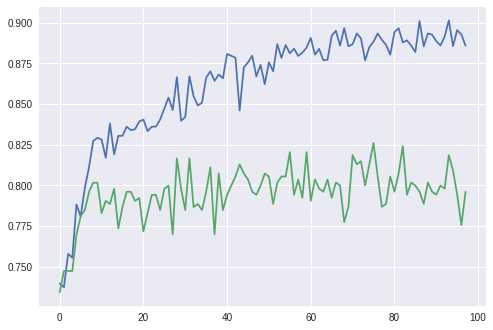

In [252]:
train_auc = []
test_auc = []

for i in range(2,100):
    clf = RandomForestClassifier(max_depth=15, max_leaf_nodes=i, min_samples_split=9,
                                 n_estimators=25)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

train_auc, test_auc

plt.plot(range(98), train_auc)
plt.plot(range(98), test_auc)

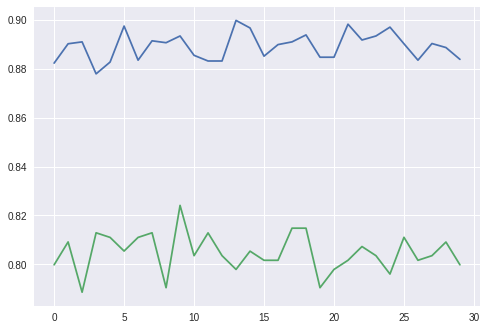

In [253]:
train_auc = []
test_auc = []

for i in range(30):
    clf = RandomForestClassifier(max_depth=15, max_leaf_nodes=80, min_samples_split=9,
                                 n_estimators=25)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

train_auc, test_auc

plt.plot(range(30), train_auc)
plt.plot(range(30), test_auc)

In [254]:
clf = RandomForestClassifier(max_depth=15, max_leaf_nodes=80, min_samples_split=9,
                                 n_estimators=25)
clf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=80,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [255]:
clf.feature_importances_

array([0.34076301, 0.22090332, 0.3060892 , 0.08610972, 0.02528607,
       0.02084868])

In [256]:
joblib.dump(clf, "final_titanic_rf.model")

['final_titanic_rf.model']

In [257]:
features_to_use = [
    "Sex_female",
    "Age",
    "Fare",
    "cat_pclass_3",
    "bin_sibsp",
    "bin_parch"
]

In [258]:
# if you want to use pickle

In [93]:
import pickle

In [94]:
filename = "./final_titanic_rf.model"

In [95]:
pickle.dump(clf, open(filename, "wb"))

In [96]:
!ls

final_titanic_rf.model		 titaniclearn.ipynb
MLND_XR_CAPSTONE_ANALYSIS.ipynb  titanic_train.csv


In [98]:
del clf

In [99]:
clf

NameError: name 'clf' is not defined

In [101]:
clf = pickle.load(open(filename, "rb"))

In [102]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=80,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [259]:
X_test[40], y_test.values.ravel()[40]

(array([-0.72224656, -0.65530714,  0.80132464, -1.13131051,  1.45653538,
        -0.55198505]), 0)

In [260]:
clf.predict([X_test[40]])

array([0])

In [261]:
clf.predict_proba([X_test[40]])

array([[0.77356022, 0.22643978]])

In [263]:
X_encoded[features_to_use].iloc[9]

Sex_female       1.0000
Age             14.0000
Fare            30.0708
cat_pclass_3     0.0000
bin_sibsp        1.0000
bin_parch        0.0000
Name: 9, dtype: float64

In [264]:
x_verification = X_encoded[features_to_use].iloc[9].values

In [265]:
x_verification

array([ 1.    , 14.    , 30.0708,  0.    ,  1.    ,  0.    ])

In [200]:
sds

StandardScaler(copy=True, with_mean=True, with_std=True)

In [266]:
sds.mean_, sds.var_

(array([ 0.34281437, 29.52778959, 32.17939671,  0.56137725,  0.32035928,
         0.23353293]),
 array([2.25292678e-01, 1.69349201e+02, 2.65898757e+03, 2.46232834e-01,
        2.17729212e-01, 1.78995303e-01]))

In [267]:
x_out = sds.transform([x_verification])

In [268]:
x_out

array([[ 1.38456873, -1.19321323, -0.04089172, -1.13131051,  1.45653538,
        -0.55198505]])

In [269]:
clf.predict(x_out)

array([1])

In [271]:
clf.predict_proba(x_out)

array([[0.1495651, 0.8504349]])